<a href="https://colab.research.google.com/github/AmirHoseein99/DigiKala_Nlp_Challenge/blob/master/MultiLabelTextClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install hazm
!pip install clean-text
!pip install catboost
!pip install imbalanced-learn

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [43]:
import warnings
warnings.filterwarnings("ignore")

import re
from hazm import *
import pandas as pd
import numpy as np
import seaborn as sns
from cleantext import clean
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from matplotlib import pyplot as plt 
from sklearn.metrics import roc_curve
from catboost import CatBoostClassifier
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import VotingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_validate
from sklearn.metrics import f1_score, accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score
from sklearn.multioutput import MultiOutputClassifier
from tensorflow.keras.preprocessing.text import Tokenizer
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.pipeline import make_pipeline as imb_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer

In [8]:
!unzip "/content/drive/MyDrive/Colab Notebooks/DataScience/DigikalaCup/Datasets/Q_4/Q_4Intent_analysis.zip"

Archive:  /content/drive/MyDrive/Colab Notebooks/DataScience/DigikalaCup/Datasets/Q_4/Q_4Intent_analysis.zip
  inflating: test.csv                
  inflating: train.csv               


In [26]:
train_set = pd.read_csv("/content/train.csv", low_memory=False)
print(10 * '*' + str(train_set.shape) + 10 * '*')
train_set.head(3)

**********(224130, 14)**********


,id,comment,product_id,product_title_fa,category_id,category_title_fa,is_buyer,price_value,fake_originality,warranty,size,discrepancy,flavor_odor,expiration_date
0,1215666.0,ارزششو داشت,2802959,جوراب مردانه فیرو پلاس مدل FP200 مجموعه 4 عددی,9456.0,جوراب و ساق مردانه,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1183149.0,یه دستگاه کاربردی فقط ای کاش طرز استفادشو میزد...,1894596,دستگاه سفید کننده دندان دنتال وایت مدل DT-1244,5745.0,مسواک برقی,True,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1011730.0,خیلی خوب و ارزان,323729,کتاب بهترین قصه ملانصرالدین کلک مرغابی اثر مهر...,5918.0,کتاب چاپی,True,1.0,0.0,0.0,0.0,0.0,0.0,0.0


Find and Drop Null Rows in our Data

In [ ]:
np.sum(train_set.isna())

id                   1
comment              3
product_id           1
product_title_fa     1
category_id          1
category_title_fa    1
is_buyer             1
price_value          1
fake_originality     1
warranty             1
size                 1
discrepancy          1
flavor_odor          1
expiration_date      2
dtype: int64

In [29]:
train_set.dropna(inplace=True)
train_set.shape

(224125, 14)

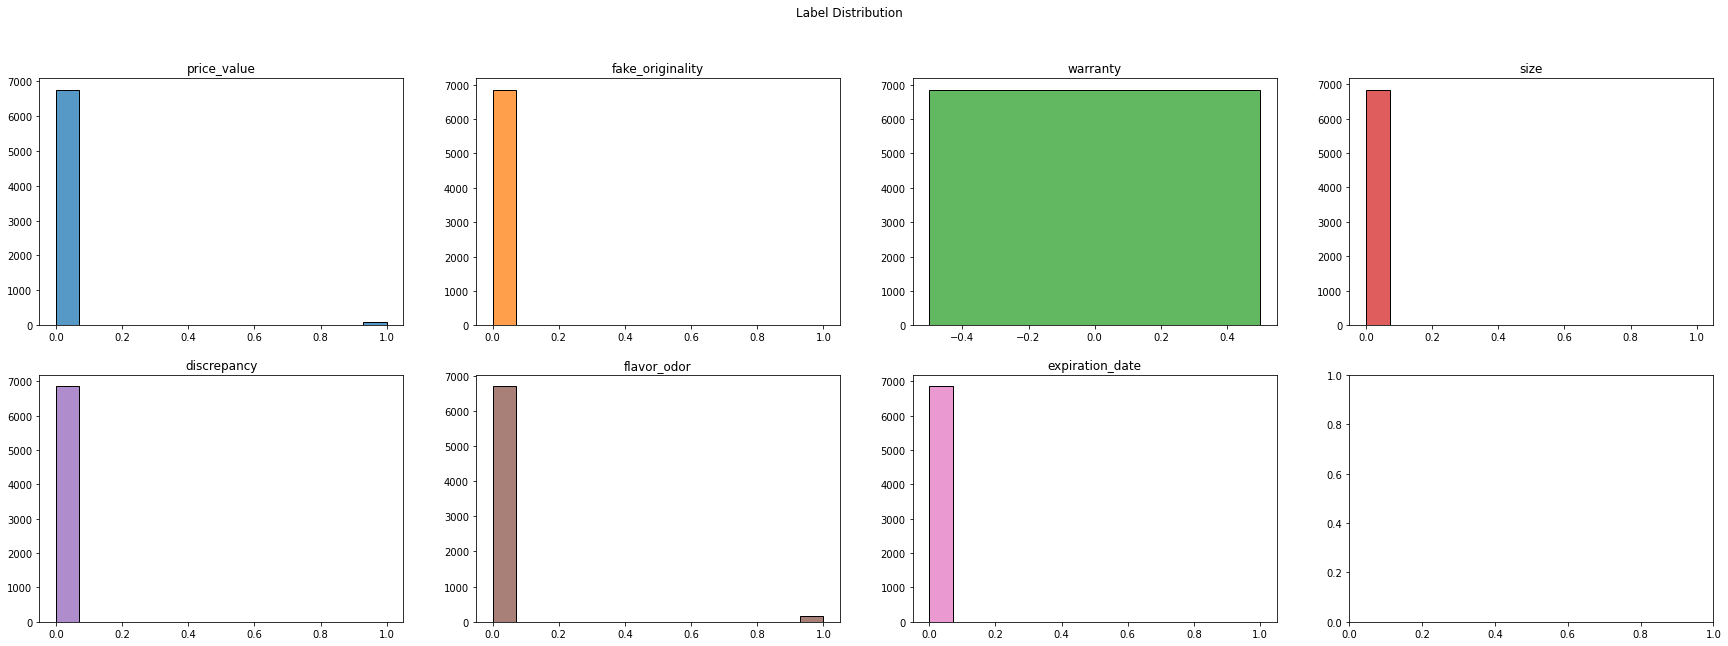

In [22]:
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
fig.suptitle('Label Distribution')
colors = plt.rcParams["axes.prop_cycle"]()
i=0
labels = train_set[["price_value", "fake_originality", "warranty", "size", "discrepancy",	"flavor_odor",	"expiration_date"]]
for label in labels.columns:
  c = next(colors)["color"]
  loc = (0 if i<4 else 1, i if i<4 else i-4)
  sns.histplot(labels[label], ax=axes[loc], color=c)
  axes[loc].set_title(label)
  axes[loc].set(xlabel=None)
  axes[loc].set(ylabel=None)
  i=i+1

max lenght: 1317, min length: 1, average length: 12
25th percentile: 4.0, 50th percentile: 8.0, 75th percentile: 15.0


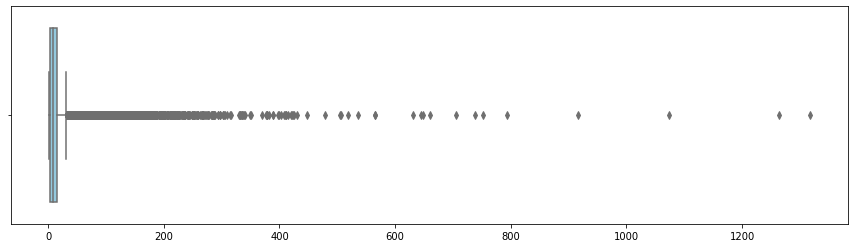

In [30]:
comment_length = np.array([len(comment.split(" ")) for comment in train_set["comment"]])
_ = plt.figure(figsize=(15, 4))
print(f"max lenght: {comment_length.max()}, min length: {comment_length.min()}, average length: {int(comment_length.mean())}")
print(f"25th percentile: {np.percentile(comment_length, 25)}, 50th percentile: {np.percentile(comment_length, 50)}, 75th percentile: {np.percentile(comment_length, 75)}")
_ = sns.boxplot(x=comment_length, color='skyblue')
_ = plt.show()

Remove comments with len > 1.5 IQR

In [31]:
train_set["comment"] = train_set.comment.apply(lambda x : x if len(x.strip(" ")) < 17 else None)
np.sum(train_set.isna())

id                        0
comment              184061
product_id                0
product_title_fa          0
category_id               0
category_title_fa         0
is_buyer                  0
price_value               0
fake_originality          0
warranty                  0
size                      0
discrepancy               0
flavor_odor               0
expiration_date           0
dtype: int64

In [32]:
train_set.dropna(inplace=True)
print(train_set.shape)

(40064, 14)


In [33]:
comments = train_set["comment"]
labels = train_set[["price_value", "fake_originality", "warranty", "size",
                    "discrepancy",	"flavor_odor",	"expiration_date"]]

Cleaning data with our valid Alphabets

In [34]:
persian_alphabet = [' ', 'ا', 'ی', 'ر', 'د', 'ن', 'و', 'ه', 'م', 'ت', 'ب', 'س', 'ک', 'ش', 'ل', 'ز',
                   'خ', 'گ', 'ف', 'ق', 'پ', 'آ', 'ج', 'ع', 'ح', 'چ', 'ص', 'ط', 'غ', 'ض', 'ذ', 'ظ', 'ث', 'ژ']
persian_erab = ['ٌ'," " , 'ً']

persian_numbers = ['۲', '۵', '۳', '۴', '۱', '۶', '۸', '۹', '۷']

lower_english_alphabet = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p','q', 'r', 's', 't', 'w', 'x', 'y', 'z', 'u']

capital_english_alphabet = [x.upper() for x in lower_english_alphabet]

english_numbers = ['1', '2','3', '4' , '0', '9', '8', '7', '6', '5']

In [35]:
translate_dict = {
          ord('ة') : ord('ه'),
			    ord('ك') : ord('ک'),
          ord('ي') : ord('ی'),
          ord('أ') : ord('ا'),
          ord('ە') : ord('ه'),
			    ord('ہ') : ord('ه'),
          ord('ے') : ord('ی'),
          ord('ڪ') : ord('ک'),
          ord('٦') : ord('۶'),
			    ord('٤') : ord('۴'),
          ord('٥') : ord('۵'),
          ord('ۻ') : ord('ض'),
			    ord('ڋ') : ord('د'),
          ord('ڕ') : ord('ر'),
          ord('ٻ') : ord('ب'),
          ord('ڑ') : ord('ر'),
			    ord('ئ') : ord('ی'),
          ord('ۀ') : ord('ه'),
          }
def clean_persian_text(text, allow_en=False, allow_eng_num=False, allow_fa_num=True):
  text = text.strip()
  text = Normalizer().normalize(text)
  valid_chars = persian_alphabet + persian_numbers + lower_english_alphabet + english_numbers
  text.translate(translate_dict)
  text = ''.join([char for char in text if char in valid_chars])
  return text

In [36]:
!git clone https://github.com/kharazi/persian-stopwords.git

with open("/content/persian-stopwords/persian", "r") as f:
  content = f.read()
  stopwords_p = content.split("\n")
  stopwords_p = stopwords_p[:-1]        
with open("/content/persian-stopwords/short", "r") as f:
  content = f.read()
  stopwords_s = content.split("\n")
  stopwords_s = stopwords_s[:-1]

with open("/content/persian-stopwords/verbal", "r") as f:
  content = f.read()
  stopwords_v = content.split("\n")
  stopwords_v = stopwords_v[:-1]

with open("/content/persian-stopwords/nonverbal", "r") as f :
  content = f.read()
  stopwords_nv = content.split("\n")
  stopwords_nv = stopwords_nv[:-1]
  

fa_stopwords = set(stopwords_p + stopwords_s + stopwords_v + stopwords_nv)

fatal: destination path 'persian-stopwords' already exists and is not an empty directory.


In [37]:
hzm_tokenize = WordTokenizer().tokenize
hzm_lemmaitze = Lemmatizer(joined_verb_parts=False).lemmatize


def my_toknizer(text):
  text_tokens = hzm_tokenize(text)
  clean_tokens = [hzm_lemmaitze(token) for token in text_tokens if token not in fa_stopwords]
  return ' '.join(clean_tokens)


In [38]:
print(f'before clean : {comments.iloc[0]}')
print(f'before clean : {comments.iloc[-1]}')


comments = comments.apply(lambda x : my_toknizer(x))

comments = comments.apply(lambda x : clean_persian_text(x))

print(f'after clean : {comments.iloc[0]}')
print(f'after clean : {comments.iloc[-1]}')

before clean : ارزششو داشت
before clean : خیلی خوبه
after clean : ارزششو
after clean : خوبه


In [61]:
X_train, X_test, y_train, y_test = train_test_split(comments, labels, random_state=42, test_size=0.2)

print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(32051,) (8013,)
(32051, 7) (8013, 7)


In [40]:
tfidf = TfidfVectorizer()
cat_boost = CatBoostClassifier(verbose=0)
xg_boost = XGBClassifier(verbose=0)
voting_clf = VotingClassifier(estimators=[('cat', cat_boost), ('xgb', xg_boost)], voting='soft')
voting_pipeline = make_pipeline(tfidf, voting_clf)
predict_probas = {}

for label_col_name in y_train.columns: 
  print(10 * '*' + label_col_name + 10 * '*' )
  voting_pipeline.fit(X_train, y_train[label_col_name])
  voting_predict = voting_pipeline.predict(X_test)
  predict_probas[label_col_name] = voting_pipeline.predict_proba(X_test)
  print(f'Test F1-Score for {label_col_name} is {f1_score(y_test[label_col_name], voting_predict)}')
  print(f'Test Accuracy for {label_col_name} is {accuracy_score(y_test[label_col_name], voting_predict)}')

**********price_value**********
Test F1-Score for price_value is 0.8416370106761566
Test Accuracy for price_value is 0.977786097591414
**********fake_originality**********
Test F1-Score for fake_originality is 0.7000000000000001
Test Accuracy for fake_originality is 0.9992512167727443
**********warranty**********
Test F1-Score for warranty is 0.0
Test Accuracy for warranty is 0.9996256083863722
**********size**********
Test F1-Score for size is 0.7826086956521738
Test Accuracy for size is 0.993136153750156
**********discrepancy**********
Test F1-Score for discrepancy is 0.6875
Test Accuracy for discrepancy is 0.9975040559091476
**********flavor_odor**********
Test F1-Score for flavor_odor is 0.9322033898305084
Test Accuracy for flavor_odor is 0.9940097341819544
**********expiration_date**********
Test F1-Score for expiration_date is 0.6666666666666666
Test Accuracy for expiration_date is 0.9996256083863722


In [62]:
oversample = SMOTE()
tfidf = TfidfVectorizer()
cat_boost = CatBoostClassifier(verbose=0)
xg_boost = XGBClassifier(verbose=0)
voting_clf = VotingClassifier(estimators=[('cat', cat_boost), ('xgb', xg_boost)], voting='soft')
smote_predict_probas = {}

SMOTE_pipeline = imb_pipeline(RandomOverSampler(), SMOTE())

X_train = tfidf.fit_transform(X_train)
X_test = tfidf.transform(X_test)

for label_col_name in y_train.columns: 
  print(10 * '*' + label_col_name + 10 * '*' )
  smote_os_X_train, smote_os_y_train = SMOTE_pipeline.fit_resample(X_train, y_train[label_col_name].to_numpy())
  voting_clf.fit(smote_os_X_train, smote_os_y_train)

  voting_predict = voting_clf.predict(X_test)
  smote_predict_probas[label_col_name] = voting_clf.predict_proba(X_test)

  print(f'Test F1-Score for {label_col_name} is {f1_score(y_test[label_col_name], voting_predict)}')
  print(f'Test Accuracy for {label_col_name} is {accuracy_score(y_test[label_col_name], voting_predict)}')

**********price_value**********
Test F1-Score for price_value is 0.8477011494252874
Test Accuracy for price_value is 0.973542992636965
**********fake_originality**********
Test F1-Score for fake_originality is 0.6666666666666666
Test Accuracy for fake_originality is 0.9988768251591165
**********warranty**********
Test F1-Score for warranty is 0.8
Test Accuracy for warranty is 0.9998752027954574
**********size**********
Test F1-Score for size is 0.7692307692307693
Test Accuracy for size is 0.9906402096593037
**********discrepancy**********
Test F1-Score for discrepancy is 0.6666666666666667
Test Accuracy for discrepancy is 0.9965056782728067
**********flavor_odor**********
Test F1-Score for flavor_odor is 0.965893587994543
Test Accuracy for flavor_odor is 0.9968800698864345
**********expiration_date**********
Test F1-Score for expiration_date is 0.06521739130434782
Test Accuracy for expiration_date is 0.9892674404093348


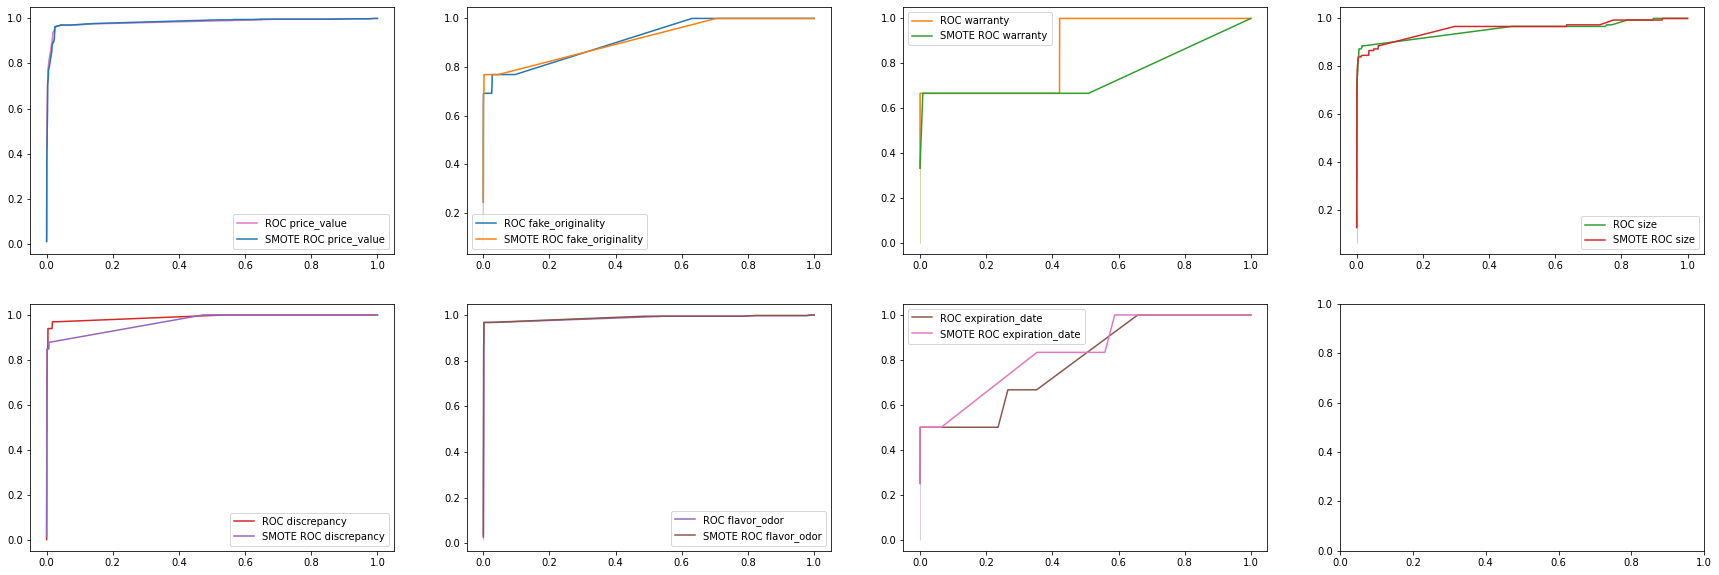

In [79]:
fig, axes = plt.subplots(2, 4, figsize=(30, 10))
colors = plt.rcParams["axes.prop_cycle"]()
j=0
for i in range(len(predict_probas)):
    loc = (0 if j<4 else 1, j if j<4 else j-4)
    col = y_test.columns[i]
    fpr, tpr, thresholds = roc_curve(y_test[col].to_numpy().reshape(-1, 1
                                                         ), predict_probas.get(col)[:, 1])
    SMOTE_fpr, SMOTE_tpr, SMOTE_thresholds = roc_curve(y_test[col].to_numpy().reshape(-1, 1), smote_predict_probas.get(col)[:, 1])
    _ = sns.lineplot(fpr, tpr, label=f"ROC {col}", ax=axes[loc], color=c)
    c = next(colors)["color"]
    _ = sns.lineplot(SMOTE_fpr, SMOTE_tpr, label=f"SMOTE ROC {col}", ax=axes[loc], color=c)
    axes[loc].set(xlabel=None)
    axes[loc].set(ylabel=None)
    j=j+1